In [79]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

# Paths to the directories containing estimate and ground truth
EST_DIR = '/home/dat/slict_ws/src/slict/evo/est'
GRT_DIR = '/home/dat/slict_ws/src/slict/evo/grt'

def load_estimate(est_path):
    """
    Load an estimated trajectory from a PCD file.
    - Skips the first 11 header lines.
    - Assumes columns: x y z intensity timestamp qx qy qz qw
    """
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    timestamps = data[:, 4]
    positions = data[:, 0:3]
    # Reorder quaternion to w,x,y,z
    quaternions = data[:, [8, 5, 6, 7]]
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quaternions,
        timestamps=timestamps
    )

def load_groundtruth(grt_path):
    """
    Load a ground truth trajectory from a CSV file.
    - Skips the header line.
    - Assumes columns: 
        col 1: timestamp,
        cols 2-4: x, y, z,
        cols 5-8: qx, qy, qz, qw  (we reorder to w, x, y, z)
    """
    data = np.loadtxt(grt_path, delimiter=',', skiprows=1)
    timestamps = data[:, 1]
    positions = data[:, [2, 3, 4]]
    quaternions = data[:, [8, 5, 6, 7]]
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quaternions,
        timestamps=timestamps
    )

def compute_rmse(traj_est, traj_gtr, max_diff=0.2):
    """
    Associate and align two trajectories, then compute translation RMSE.
    - max_diff: maximum timestamp difference (in seconds) for association
    """
    est_sync, gtr_sync = sync.associate_trajectories(
        traj_est, traj_gtr, max_diff=max_diff
    )
    est_sync.align(gtr_sync)
    ape_metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
    ape_metric.process_data((gtr_sync, est_sync))
    return float(
        ape_metric
        .get_result(ref_name='reference', est_name='estimate')
        .stats['rmse']
    )

def process_all_sets():
    # Find common subfolders in EST_DIR and GRT_DIR (e.g., ntu_day_01, ntu_day_02, ...)
    est_sets = [d for d in os.listdir(EST_DIR) if os.path.isdir(os.path.join(EST_DIR, d))]
    grt_sets = [d for d in os.listdir(GRT_DIR) if os.path.isdir(os.path.join(GRT_DIR, d))]
    common_sets = sorted(set(est_sets) & set(grt_sets))

    results = {}
    for subset in common_sets:
        # Locate .pcd and .csv files within each subfolder
        est_files = glob.glob(os.path.join(EST_DIR, subset, '*.pcd'))
        grt_files = glob.glob(os.path.join(GRT_DIR, subset, '*.csv'))

        if not est_files or not grt_files:
            print(f"[WARN] Skipping {subset}: missing .pcd or .csv file")
            continue

        est_path = est_files[0]  # take the first found estimate file
        grt_path = grt_files[0]  # take the first found ground truth file

        print(f"Processing set {subset}...")
        traj_est = load_estimate(est_path)
        traj_gtr = load_groundtruth(grt_path)
        rmse = compute_rmse(traj_est, traj_gtr)
        results[subset] = rmse

        # Optional: plot the aligned trajectories
        # fig, ax = plt.subplots(figsize=(8, 8))
        # ax.plot(
        #     traj_est.positions_xyz[:, 0],
        #     traj_est.positions_xyz[:, 1],
        #     '-', label='estimate (aligned)'
        # )
        # ax.plot(
        #     traj_gtr.positions_xyz[:, 0],
        #     traj_gtr.positions_xyz[:, 1],
        #     '--', label='ground truth'
        # )
        # ax.set_aspect('equal')
        # ax.set_title(f"{subset} — RMSE = {rmse:.3f} m")
        # ax.set_xlabel('X [m]')
        # ax.set_ylabel('Y [m]')
        # ax.legend()
        # ax.grid(True)
        # plt.show()

    # Print summary of RMSE for all sets
    print("\nSummary of RMSE for all processed sets:")
    for subset, rmse_val in results.items():
        print(f"  {subset}: {rmse_val:.3f} m")

if __name__ == '__main__':
    process_all_sets()


Processing set ntu_day_01...
Processing set ntu_day_02...
Processing set ntu_day_03...
Processing set ntu_day_04...
Processing set ntu_day_05...
Processing set ntu_day_06...
Processing set ntu_day_07...
Processing set ntu_day_08...
Processing set ntu_day_09...
Processing set ntu_day_10...
Processing set ntu_night_01...
Processing set ntu_night_02...
Processing set ntu_night_03...
Processing set ntu_night_04...
Processing set ntu_night_05...
Processing set ntu_night_06...
Processing set ntu_night_07...
Processing set ntu_night_08...
Processing set ntu_night_09...
Processing set ntu_night_10...
Processing set ntu_night_11...
Processing set ntu_night_12...
Processing set ntu_night_13...

Summary of RMSE for all processed sets:
  ntu_day_01: 0.035 m
  ntu_day_02: 0.023 m
  ntu_day_03: 0.031 m
  ntu_day_04: 0.031 m
  ntu_day_05: 0.033 m
  ntu_day_06: 0.176 m
  ntu_day_07: 0.030 m
  ntu_day_08: 0.033 m
  ntu_day_09: 0.145 m
  ntu_day_10: 0.038 m
  ntu_night_01: 0.022 m
  ntu_night_02: 0.025 

In [81]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

# ====== Paths ======
EST_DIR = '/home/dat/slict_ws/src/slict/evo/slict2_nomap'
GRT_DIR = '/home/dat/slict_ws/src/slict/evo/grt'

# ====== Chỉ xử lý các tập này ======
TARGET_SETS = ['ntu_day_02', 'ntu_day_10', 'ntu_night_02', 'ntu_night_04', 'ntu_night_13']


def euler_rpy_to_quat_wxyz(roll, pitch, yaw, assume_deg_if_large=True):
    """Convert roll, pitch, yaw -> quaternion (w,x,y,z). Góc nhập là rad;
    nếu trị số lớn (>|~2π|) thì coi là độ và tự đổi sang rad."""
    r = np.asarray(roll, dtype=float)
    p = np.asarray(pitch, dtype=float)
    y = np.asarray(yaw, dtype=float)

    if r.size and p.size and y.size:
        max_abs = np.nanmax(np.abs([np.nanmax(r), np.nanmax(p), np.nanmax(y)]))
    else:
        max_abs = 0.0
    if assume_deg_if_large and max_abs > 6.4:  # ~> 2π
        d2r = np.pi / 180.0
        r, p, y = r * d2r, p * d2r, y * d2r

    cr, sr = np.cos(r * 0.5), np.sin(r * 0.5)
    cp, sp = np.cos(p * 0.5), np.sin(p * 0.5)
    cy, sy = np.cos(y * 0.5), np.sin(y * 0.5)

    # ZYX (yaw-pitch-roll)
    qw = cr*cp*cy + sr*sp*sy
    qx = sr*cp*cy - cr*sp*sy
    qy = cr*sp*cy + sr*cp*sy
    qz = cr*cp*sy - sr*sp*cy
    return np.column_stack([qw, qx, qy, qz])


def load_estimate(est_path):
    """
    Load trajectory ước lượng từ PCD/TXT.
    - Bỏ 11 dòng header.
    - Tự nhận diện 2 format:
        (A) x y z intensity timestamp qx qy qz qw
        (B) x y z intensity roll pitch yaw time
    """
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    positions = data[:, 0:3]

    quat_wxyz = None
    timestamps = None

    # Thử format (A): q ở cột 5..8 (qx qy qz qw), time ở cột 4
    if data.shape[1] >= 9:
        qx, qy, qz, qw = data[:, 5], data[:, 6], data[:, 7], data[:, 8]
        q_norm = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
        # Nếu norm ~ 1 => nhiều khả năng là quaternion
        if np.nanmedian(q_norm) > 0.7 and np.nanmedian(q_norm) < 1.3:
            timestamps = data[:, 4]
            quat_wxyz = np.column_stack([qw, qx, qy, qz])

    # Nếu không phải (A), rơi về (B): RPY ở 4..6, time ở 7
    if quat_wxyz is None:
        roll, pitch, yaw = data[:, 4], data[:, 5], data[:, 6]
        timestamps = data[:, 7]
        quat_wxyz = euler_rpy_to_quat_wxyz(roll, pitch, yaw)

    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quat_wxyz,
        timestamps=timestamps
    )


def load_groundtruth(grt_path):
    """
    Load ground truth từ CSV (bỏ 1 dòng header).
    Giả định:
      col1: (index/unused), col2: timestamp, col3-5: x y z, col6-9: qx qy qz qw
    -> nếu khác, chỉnh lại các chỉ số cột bên dưới cho đúng file của bạn.
    """
    data = np.loadtxt(grt_path, delimiter=',', skiprows=1)
    # Chỉnh theo giả định phổ biến: [id, t, x, y, z, qx, qy, qz, qw]
    timestamps = data[:, 1]
    positions  = data[:, [2, 3, 4]]
    qx, qy, qz, qw = data[:, 5], data[:, 6], data[:, 7], data[:, 8]
    quaternions = np.column_stack([qw, qx, qy, qz])
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quaternions,
        timestamps=timestamps
    )


def sync_and_align(est_traj, gtr_traj, max_diff=0.2):
    """
    Đồng bộ timestamp và align SE(3) ước lượng vào khung GT.
    Trả về (est_sync_aligned, gtr_sync).
    """
    est_sync, gtr_sync = sync.associate_trajectories(est_traj, gtr_traj, max_diff=max_diff)
    # Align in-place est -> gtr
    est_sync.align(gtr_sync)
    return est_sync, gtr_sync


def compute_rmse_from_synced(est_sync_aligned, gtr_sync):
    """Tính APE (translation) RMSE từ 2 traj đã sync + align."""
    ape_metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
    ape_metric.process_data((gtr_sync, est_sync_aligned))
    rmse = ape_metric.get_result(ref_name='reference', est_name='estimate').stats['rmse']
    return float(rmse)


def plot_xy_after_align(est_sync_aligned, gtr_sync, title):
    """Vẽ XY sau khi đã align (est vào khung gtr)."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1], '--', label='ground truth')
    ax.plot(est_sync_aligned.positions_xyz[:, 0], est_sync_aligned.positions_xyz[:, 1], '-',  label='estimate (aligned)')
    # đánh dấu điểm đầu/cuối cho dễ so
    ax.plot(gtr_sync.positions_xyz[0, 0], gtr_sync.positions_xyz[0, 1], 'o', label='GT start')
    ax.plot(est_sync_aligned.positions_xyz[0, 0], est_sync_aligned.positions_xyz[0, 1], 'x', label='EST start')
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.grid(True)
    ax.legend()
    plt.show()


def process_all_sets():
    # Lọc những subfolder có ở cả EST_DIR & GRT_DIR và thuộc TARGET_SETS
    est_sets = [d for d in os.listdir(EST_DIR) if os.path.isdir(os.path.join(EST_DIR, d))]
    grt_sets = [d for d in os.listdir(GRT_DIR) if os.path.isdir(os.path.join(GRT_DIR, d))]
    common_sets = [s for s in TARGET_SETS if (s in est_sets and s in grt_sets)]

    results = {}
    for subset in common_sets:
        est_files = glob.glob(os.path.join(EST_DIR, subset, '*.pcd')) or \
                    glob.glob(os.path.join(EST_DIR, subset, '*.txt'))
        grt_files = glob.glob(os.path.join(GRT_DIR, subset, '*.csv'))

        if not est_files or not grt_files:
            print(f"[WARN] Skipping {subset}: missing .pcd/.txt or .csv file")
            continue

        est_path = est_files[0]
        grt_path = grt_files[0]

        print(f"Processing set {subset}...")
        traj_est = load_estimate(est_path)
        traj_gtr = load_groundtruth(grt_path)

        try:
            # 1) sync + align
            est_aligned, gtr_sync = sync_and_align(traj_est, traj_gtr, max_diff=0.5)
            # 2) RMSE
            rmse = compute_rmse_from_synced(est_aligned, gtr_sync)
            results[subset] = rmse
            title = f"{subset} — RMSE = {rmse:.3f} m"
        except Exception as e:
            print(f"[ERROR] {subset}: {e}")
            results[subset] = None
            title = f"{subset} — RMSE = N/A (sync/align failed)"

        # 3) Vẽ XY sau align (nếu OK), nếu fail thì vẽ raw cho tham khảo
        # try:
        #     if results[subset] is not None:
        #         # plot_xy_after_align(est_aligned, gtr_sync, title)
        #     else:
        #         # fallback: vẽ raw (chưa align)
        #         fig, ax = plt.subplots(figsize=(8, 8))
        #         ax.plot(traj_gtr.positions_xyz[:, 0], traj_gtr.positions_xyz[:, 1], '--', label='ground truth')
        #         ax.plot(traj_est.positions_xyz[:, 0], traj_est.positions_xyz[:, 1], '-',  label='estimate (raw)')
        #         ax.set_aspect('equal')
        #         ax.set_title(title)
        #         ax.set_xlabel('X [m]')
        #         ax.set_ylabel('Y [m]')
        #         ax.grid(True)
        #         ax.legend()
        #         plt.show()
        # except Exception as e:
        #     print(f"[WARN] Plot failed for {subset}: {e}")

    # Tóm tắt
    print("\nSummary of RMSE for selected sets:")
    for subset in TARGET_SETS:
        val = results.get(subset, None)
        if isinstance(val, float):
            print(f"  {subset}: {val:.3f} m")
        elif subset in common_sets:
            print(f"  {subset}: N/A")
        else:
            print(f"  {subset}: (missing est/grt)")


if __name__ == '__main__':
    process_all_sets()


Processing set ntu_day_02...
Processing set ntu_day_10...
Processing set ntu_night_02...
Processing set ntu_night_04...
Processing set ntu_night_13...

Summary of RMSE for selected sets:
  ntu_day_02: 0.259 m
  ntu_day_10: 1.838 m
  ntu_night_02: 2.065 m
  ntu_night_04: 2.209 m
  ntu_night_13: 1.096 m


In [14]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

# ====== Paths ======
EST_DIR = '/home/dat/slict_ws/src/slict/evo/liosam_lc'
GRT_DIR = '/home/dat/slict_ws/src/slict/evo/grt'

# ====== Chỉ xử lý các tập này ======
TARGET_SETS = ['ntu_day_02', 'ntu_day_10', 'ntu_night_02', 'ntu_night_04', 'ntu_night_13']


def euler_rpy_to_quat_wxyz(roll, pitch, yaw, assume_deg_if_large=True):
    """Convert roll, pitch, yaw -> quaternion (w,x,y,z). Góc nhập là rad;
    nếu trị số lớn (>|~2π|) thì coi là độ và tự đổi sang rad."""
    r = np.asarray(roll, dtype=float)
    p = np.asarray(pitch, dtype=float)
    y = np.asarray(yaw, dtype=float)

    if r.size and p.size and y.size:
        max_abs = np.nanmax(np.abs([np.nanmax(r), np.nanmax(p), np.nanmax(y)]))
    else:
        max_abs = 0.0
    if assume_deg_if_large and max_abs > 6.4:  # ~> 2π
        d2r = np.pi / 180.0
        r, p, y = r * d2r, p * d2r, y * d2r

    cr, sr = np.cos(r * 0.5), np.sin(r * 0.5)
    cp, sp = np.cos(p * 0.5), np.sin(p * 0.5)
    cy, sy = np.cos(y * 0.5), np.sin(y * 0.5)

    # ZYX (yaw-pitch-roll)
    qw = cr*cp*cy + sr*sp*sy
    qx = sr*cp*cy - cr*sp*sy
    qy = cr*sp*cy + sr*cp*sy
    qz = cr*cp*sy - sr*sp*cy
    return np.column_stack([qw, qx, qy, qz])


def load_estimate(est_path):
    """
    Load trajectory ước lượng từ PCD/TXT.
    - Bỏ 11 dòng header.
    - Tự nhận diện 2 format:
        (A) x y z intensity timestamp qx qy qz qw
        (B) x y z intensity roll pitch yaw time
    """
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    positions = data[:, 0:3]

    quat_wxyz = None
    timestamps = None

    # Thử format (A): q ở cột 5..8 (qx qy qz qw), time ở cột 4
    if data.shape[1] >= 9:
        qx, qy, qz, qw = data[:, 5], data[:, 6], data[:, 7], data[:, 8]
        q_norm = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
        # Nếu norm ~ 1 => nhiều khả năng là quaternion
        if np.nanmedian(q_norm) > 0.7 and np.nanmedian(q_norm) < 1.3:
            timestamps = data[:, 4]
            quat_wxyz = np.column_stack([qw, qx, qy, qz])

    # Nếu không phải (A), rơi về (B): RPY ở 4..6, time ở 7
    if quat_wxyz is None:
        roll, pitch, yaw = data[:, 4], data[:, 5], data[:, 6]
        timestamps = data[:, 7]
        quat_wxyz = euler_rpy_to_quat_wxyz(roll, pitch, yaw)

    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quat_wxyz,
        timestamps=timestamps
    )


def load_groundtruth(grt_path):
    """
    Load ground truth từ CSV (bỏ 1 dòng header).
    Giả định:
      col1: (index/unused), col2: timestamp, col3-5: x y z, col6-9: qx qy qz qw
    -> nếu khác, chỉnh lại các chỉ số cột bên dưới cho đúng file của bạn.
    """
    data = np.loadtxt(grt_path, delimiter=',', skiprows=1)
    # Chỉnh theo giả định phổ biến: [id, t, x, y, z, qx, qy, qz, qw]
    timestamps = data[:, 1]
    positions  = data[:, [2, 3, 4]]
    qx, qy, qz, qw = data[:, 5], data[:, 6], data[:, 7], data[:, 8]
    quaternions = np.column_stack([qw, qx, qy, qz])
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quaternions,
        timestamps=timestamps
    )


def sync_and_align(est_traj, gtr_traj, max_diff=0.2):
    """
    Đồng bộ timestamp và align SE(3) ước lượng vào khung GT.
    Trả về (est_sync_aligned, gtr_sync).
    """
    est_sync, gtr_sync = sync.associate_trajectories(est_traj, gtr_traj, max_diff=max_diff)
    # Align in-place est -> gtr
    est_sync.align(gtr_sync)
    return est_sync, gtr_sync


def compute_rmse_from_synced(est_sync_aligned, gtr_sync):
    """Tính APE (translation) RMSE từ 2 traj đã sync + align."""
    ape_metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
    ape_metric.process_data((gtr_sync, est_sync_aligned))
    rmse = ape_metric.get_result(ref_name='reference', est_name='estimate').stats['rmse']
    return float(rmse)


def plot_xy_after_align(est_sync_aligned, gtr_sync, title):
    """Vẽ XY sau khi đã align (est vào khung gtr)."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1], '--', label='ground truth')
    ax.plot(est_sync_aligned.positions_xyz[:, 0], est_sync_aligned.positions_xyz[:, 1], '-',  label='estimate (aligned)')
    # đánh dấu điểm đầu/cuối cho dễ so
    ax.plot(gtr_sync.positions_xyz[0, 0], gtr_sync.positions_xyz[0, 1], 'o', label='GT start')
    ax.plot(est_sync_aligned.positions_xyz[0, 0], est_sync_aligned.positions_xyz[0, 1], 'x', label='EST start')
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.grid(True)
    ax.legend()
    


def process_all_sets():
    # Lọc những subfolder có ở cả EST_DIR & GRT_DIR và thuộc TARGET_SETS
    est_sets = [d for d in os.listdir(EST_DIR) if os.path.isdir(os.path.join(EST_DIR, d))]
    grt_sets = [d for d in os.listdir(GRT_DIR) if os.path.isdir(os.path.join(GRT_DIR, d))]
    common_sets = [s for s in TARGET_SETS if (s in est_sets and s in grt_sets)]

    results = {}
    for subset in common_sets:
        est_files = glob.glob(os.path.join(EST_DIR, subset, '*.pcd')) or \
                    glob.glob(os.path.join(EST_DIR, subset, '*.txt'))
        grt_files = glob.glob(os.path.join(GRT_DIR, subset, '*.csv'))

        if not est_files or not grt_files:
            print(f"[WARN] Skipping {subset}: missing .pcd/.txt or .csv file")
            continue

        est_path = est_files[0]
        grt_path = grt_files[0]

        print(f"Processing set {subset}...")
        traj_est = load_estimate(est_path)
        traj_gtr = load_groundtruth(grt_path)

        try:
            # 1) sync + align
            est_aligned, gtr_sync = sync_and_align(traj_est, traj_gtr, max_diff=0.5)
            # 2) RMSE
            rmse = compute_rmse_from_synced(est_aligned, gtr_sync)
            results[subset] = rmse
            title = f"{subset} — RMSE = {rmse:.3f} m"
        except Exception as e:
            print(f"[ERROR] {subset}: {e}")
            results[subset] = None
            title = f"{subset} — RMSE = N/A (sync/align failed)"

        # 3) Vẽ XY sau align (nếu OK), nếu fail thì vẽ raw cho tham khảo
        # try:
        #     if results[subset] is not None:
        #         # plot_xy_after_align(est_aligned, gtr_sync, title)
        #     else:
        #         # fallback: vẽ raw (chưa align)
        #         fig, ax = plt.subplots(figsize=(8, 8))
        #         ax.plot(traj_gtr.positions_xyz[:, 0], traj_gtr.positions_xyz[:, 1], '--', label='ground truth')
        #         ax.plot(traj_est.positions_xyz[:, 0], traj_est.positions_xyz[:, 1], '-',  label='estimate (raw)')
        #         ax.set_aspect('equal')
        #         ax.set_title(title)
        #         ax.set_xlabel('X [m]')
        #         ax.set_ylabel('Y [m]')
        #         ax.grid(True)
        #         ax.legend()
        #         plt.show()
        # except Exception as e:
        #     print(f"[WARN] Plot failed for {subset}: {e}")

    # Tóm tắt
    print("\nSummary of RMSE for selected sets:")
    for subset in TARGET_SETS:
        val = results.get(subset, None)
        if isinstance(val, float):
            print(f"  {subset}: {val:.3f} m")
        elif subset in common_sets:
            print(f"  {subset}: N/A")
        else:
            print(f"  {subset}: (missing est/grt)")


if __name__ == '__main__':
    process_all_sets()


Processing set ntu_day_02...
Processing set ntu_day_10...
Processing set ntu_night_02...
Processing set ntu_night_04...
Processing set ntu_night_13...

Summary of RMSE for selected sets:
  ntu_day_02: 0.316 m
  ntu_day_10: 0.709 m
  ntu_night_02: 0.783 m
  ntu_night_04: 0.759 m
  ntu_night_13: 0.982 m


Processing set ntu_day_02...


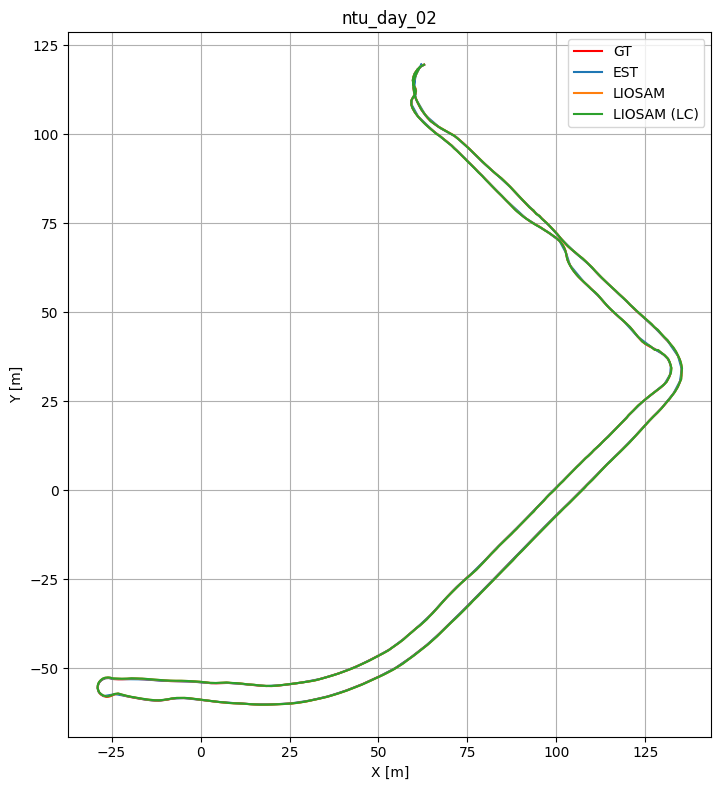

Processing set ntu_day_10...


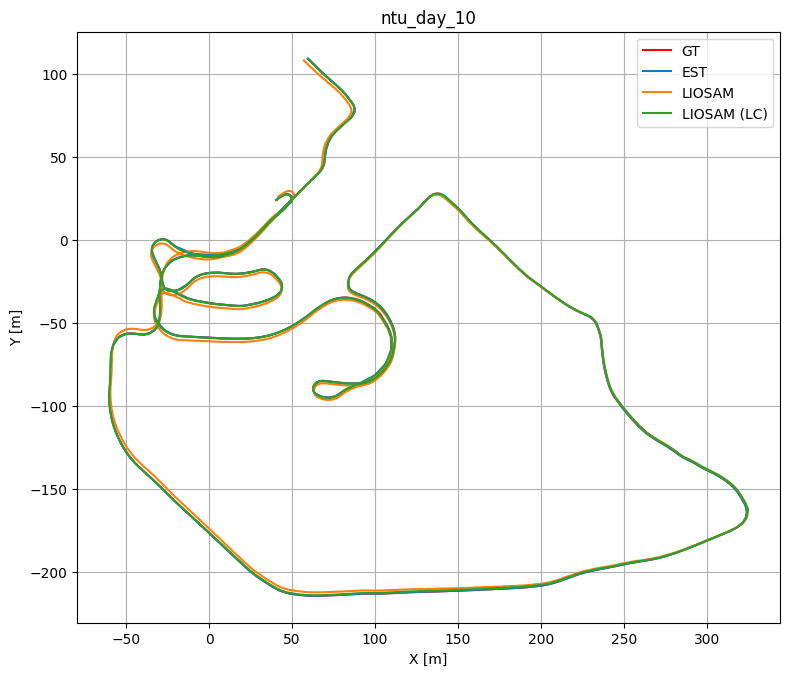

Processing set ntu_night_02...


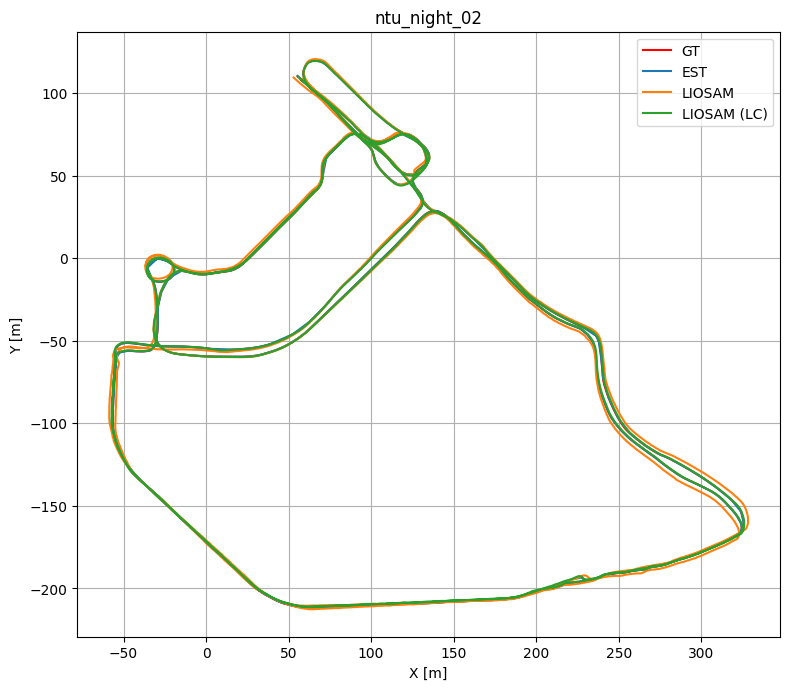

Processing set ntu_night_04...


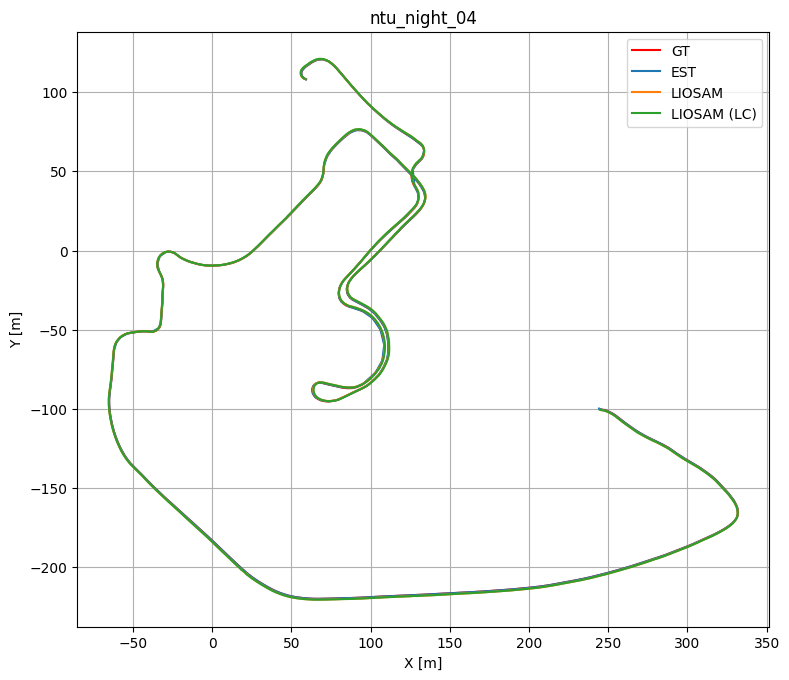

Processing set ntu_night_13...


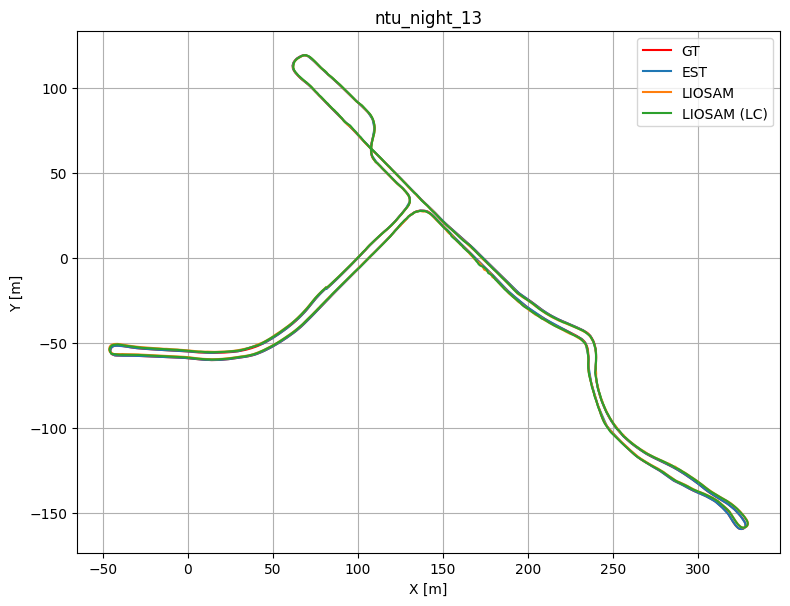

In [65]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# ====== Paths ======
EST_DIR_A = '/home/dat/slict_ws/src/slict/evo/est'        # EST (của bạn) — quat + time
EST_DIR_B = '/home/dat/slict_ws/src/slict/evo/liosam'     # LIOSAM — RPY + time
EST_DIR_C = '/home/dat/slict_ws/src/slict/evo/liosam_lc'  # LIOSAM (LC) — RPY + time
GRT_DIR   = '/home/dat/slict_ws/src/slict/evo/grt'

# ====== Chỉ xử lý 5 tập NTU ======
TARGET_SETS = ['ntu_day_02', 'ntu_day_10', 'ntu_night_02', 'ntu_night_04', 'ntu_night_13']


def euler_rpy_to_quat_wxyz(roll, pitch, yaw, assume_deg_if_large=True):
    """Convert RPY -> quaternion (w,x,y,z). Input mặc định rad; nếu trị số lớn coi là độ."""
    r = np.asarray(roll, dtype=float)
    p = np.asarray(pitch, dtype=float)
    y = np.asarray(yaw, dtype=float)

    if assume_deg_if_large:
        max_abs = np.nanmax(np.abs([np.nanmax(r), np.nanmax(p), np.nanmax(y)]))
        if max_abs > 6.4:  # ~> 2π
            d2r = np.pi / 180.0
            r, p, y = r * d2r, p * d2r, y * d2r

    cr, sr = np.cos(r * 0.5), np.sin(r * 0.5)
    cp, sp = np.cos(p * 0.5), np.sin(p * 0.5)
    cy, sy = np.cos(y * 0.5), np.sin(y * 0.5)

    # yaw(Z)-pitch(Y)-roll(X) order (ZYX)
    qw = cr*cp*cy + sr*sp*sy
    qx = sr*cp*cy - cr*sp*sy
    qy = cr*sp*cy + sr*cp*sy
    qz = cr*cp*sy - sr*sp*cy
    return np.column_stack([qw, qx, qy, qz])


# ---------- Loaders ----------
def load_estimate_est(est_path):
    """
    EST (của bạn): PCD/TXT bỏ 11 dòng header.
    Cột: x y z intensity timestamp qx qy qz qw
    """
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    timestamps = data[:, 4]
    positions  = data[:, 0:3]
    quats_wxyz = data[:, [8, 5, 6, 7]]   # reorder: qw qx qy qz
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


def load_estimate_liosam_like(est_path):
    """
    Cho LIOSAM/LIOSAM_LC: PCD/TXT bỏ 11 dòng header.
    Cột: x y z intensity roll pitch yaw time
    """
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    positions  = data[:, 0:3]
    roll, pitch, yaw = data[:, 4], data[:, 5], data[:, 6]
    timestamps = data[:, 7]
    quats_wxyz = euler_rpy_to_quat_wxyz(roll, pitch, yaw)
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


def load_groundtruth(grt_path):
    """
    GT CSV (bỏ 1 dòng header):
      [id, t, x, y, z, qx, qy, qz, qw] -> reorder [w,x,y,z]
    """
    data = np.loadtxt(grt_path, delimiter=',', skiprows=1)
    timestamps = data[:, 1]
    positions  = data[:, [2, 3, 4]]
    quats_wxyz = data[:, [8, 5, 6, 7]]
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


# ---------- Sync & plot ----------
def associate_and_align(traj_est, traj_gtr, max_diff=0.5):
    """
    Đồng bộ theo thời gian & align est vào khung GT.
    Trả về: (est_aligned, gtr_synced)
    """
    est_sync, gtr_sync = sync.associate_trajectories(traj_est, traj_gtr, max_diff=max_diff)
    est_sync.align(gtr_sync)  # in-place
    return est_sync, gtr_sync


def plot_xy_three_estimates(estA_aligned, estB_aligned, estC_aligned, gtr_sync, title):
    """Vẽ XY: GT (đỏ) + EST + LIOSAM + LIOSAM (LC) trên 1 hình. Không vẽ điểm start."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(gtr_sync.positions_xyz[:, 0],  gtr_sync.positions_xyz[:, 1],  '-',  color='red', label='GT')
    ax.plot(estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1], '-', label='EST')
    ax.plot(estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1], '-', label='LIOSAM')
    ax.plot(estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1], '-', label='LIOSAM (LC)')

    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_xy_three_estimates_with_zoom(
    estA_aligned, estB_aligned, estC_aligned, gtr_sync, title,
    inset_xlim=(100, 150), inset_ylim=(-214, -210),  # KHUNG ZOOM (đổi theo tập của bạn)
    zoom=3.0, inset_loc='upper right'                # độ phóng to & vị trí ô zoom
):
    fig, ax = plt.subplots(figsize=(8, 8))

    # --- Plot chính ---
    ax.plot(gtr_sync.positions_xyz[:, 0],  gtr_sync.positions_xyz[:, 1],  '-',  color='red', label='GT')
    ax.plot(estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1], '-', label='EST')
    ax.plot(estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1], '-', label='LIOSAM')
    ax.plot(estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1], '-', label='LIOSAM (LC)')

    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.grid(True)
    ax.legend()

    # --- Ô zoom (inset) ---
    axins = zoomed_inset_axes(ax, zoom=zoom, loc=inset_loc)  # tạo axes con
    # vẽ lại y hệt các đường vào ô zoom
    axins.plot(gtr_sync.positions_xyz[:, 0],  gtr_sync.positions_xyz[:, 1],  '-',  color='red')
    axins.plot(estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1], '-')
    axins.plot(estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1], '-')
    axins.plot(estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1], '-')

    # đặt vùng hiển thị cần phóng to
    axins.set_xlim(*inset_xlim)
    axins.set_ylim(*inset_ylim)

    # gọn gàng: ẩn tick/nhãn trong ô zoom
    axins.set_xticks([]); axins.set_yticks([])

    # vẽ khung chữ nhật + 2 đường nối giữa ô zoom và vùng tương ứng
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3", linestyle="--", linewidth=1.0)

    plt.tight_layout()
    plt.show()


def process_all_sets():
    # Lọc các tập tồn tại ở cả bốn thư mục và thuộc TARGET_SETS
    sets_a = [d for d in os.listdir(EST_DIR_A) if os.path.isdir(os.path.join(EST_DIR_A, d))]
    sets_b = [d for d in os.listdir(EST_DIR_B) if os.path.isdir(os.path.join(EST_DIR_B, d))]
    sets_c = [d for d in os.listdir(EST_DIR_C) if os.path.isdir(os.path.join(EST_DIR_C, d))]
    sets_g = [d for d in os.listdir(GRT_DIR)   if os.path.isdir(os.path.join(GRT_DIR, d))]
    common_sets = [s for s in TARGET_SETS if (s in sets_a and s in sets_b and s in sets_c and s in sets_g)]

    for subset in common_sets:
        estA_files = glob.glob(os.path.join(EST_DIR_A, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_A, subset, '*.txt'))
        estB_files = glob.glob(os.path.join(EST_DIR_B, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_B, subset, '*.txt'))
        estC_files = glob.glob(os.path.join(EST_DIR_C, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_C, subset, '*.txt'))
        grt_files  = glob.glob(os.path.join(GRT_DIR,   subset, '*.csv'))

        if not estA_files or not estB_files or not estC_files or not grt_files:
            print(f"[WARN] Skipping {subset}: missing EST/LIOSAM/LIOSAM_LC/GT file")
            continue

        estA_path = estA_files[0]
        estB_path = estB_files[0]
        estC_path = estC_files[0]
        grt_path  = grt_files[0]

        print(f"Processing set {subset}...")

        traj_estA = load_estimate_est(estA_path)           # EST của bạn (quat + time)
        traj_estB = load_estimate_liosam_like(estB_path)   # LIOSAM (rpy + time)
        traj_estC = load_estimate_liosam_like(estC_path)   # LIOSAM (LC) (rpy + time)
        traj_gtr  = load_groundtruth(grt_path)

        try:
            # Align từng est vào cùng GT để vẽ chung
            estA_aligned, gtr_syncA = associate_and_align(traj_estA, traj_gtr, max_diff=0.2)
            estB_aligned, gtr_syncB = associate_and_align(traj_estB, traj_gtr, max_diff=0.2)
            estC_aligned, gtr_syncC = associate_and_align(traj_estC, traj_gtr, max_diff=0.2)

            # Chọn GT sync dài nhất để chú thích/vẽ
            gtrs = [gtr_syncA, gtr_syncB, gtr_syncC]
            gtr_sync = max(gtrs, key=lambda g: g.positions_xyz.shape[0])

            title = f"{subset}"
            plot_xy_three_estimates(estA_aligned, estB_aligned, estC_aligned, gtr_sync, title)

        except Exception as e:
            print(f"[ERROR] {subset}: {e}")
            # fallback: vẽ raw nếu align lỗi
            try:
                fig, ax = plt.subplots(figsize=(8, 8))
                ax.plot(traj_estA.positions_xyz[:, 0], traj_estA.positions_xyz[:, 1], '-',  label='EST (raw)')
                ax.plot(traj_estB.positions_xyz[:, 0], traj_estB.positions_xyz[:, 1], '-',  label='LIOSAM (raw)')
                ax.plot(traj_estC.positions_xyz[:, 0], traj_estC.positions_xyz[:, 1], '-',  label='LIOSAM (LC) (raw)')
                ax.set_aspect('equal')
                ax.set_title(f"{subset} — (raw, align failed)")
                ax.set_xlabel('X [m]')
                ax.set_ylabel('Y [m]')
                ax.grid(True)
                ax.legend()
                plt.tight_layout()
                plt.show()
            except Exception as e2:
                print(f"[WARN] Plot raw failed for {subset}: {e2}")

if __name__ == '__main__':
    process_all_sets()
    


Processing set ntu_day_02...


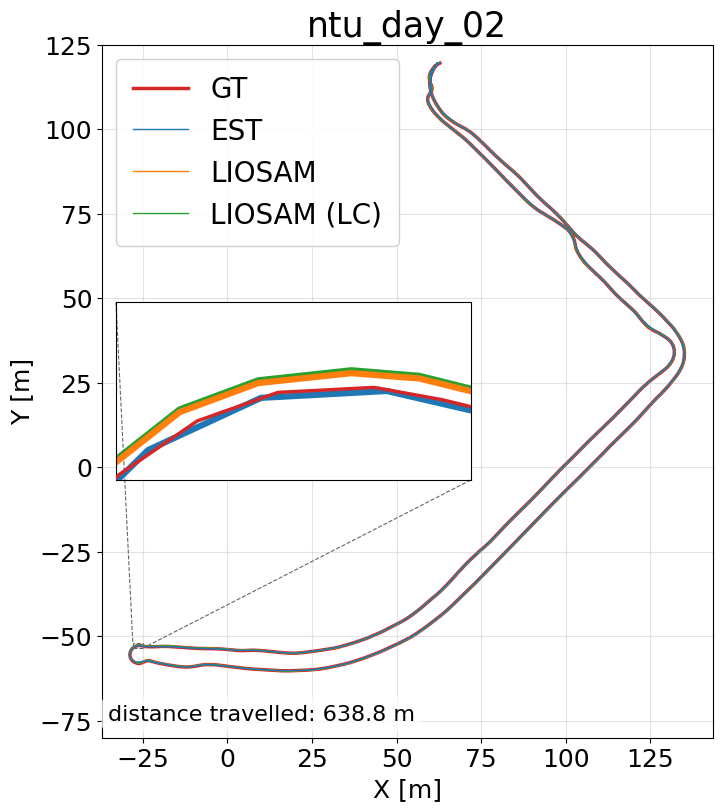

In [145]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# ====== Paths ======
EST_DIR_A = '/home/dat/slict_ws/src/slict/evo/est'        # EST (của bạn) — quat + time
EST_DIR_B = '/home/dat/slict_ws/src/slict/evo/liosam'     # LIOSAM — RPY + time
EST_DIR_C = '/home/dat/slict_ws/src/slict/evo/liosam_lc'  # LIOSAM (LC) — RPY + time
GRT_DIR   = '/home/dat/slict_ws/src/slict/evo/grt'

# ====== Chỉ xử lý 1 (hoặc vài) tập ======
TARGET_SETS = ['ntu_day_02']  # thêm tên khác nếu muốn

# ==== Màu sắc nhất quán ====
COL_EST   = '#1f77b4'  # EST:    xanh dương
COL_LIOS  = '#ff7f0e'  # LIO-SAM: cam
COL_LC    = '#2ca02c'  # LIO-SAM (LC): xanh lá
COL_GT    = '#d62728'  # GT:     đỏ

# ==== Thiết lập font lớn toàn cục ====
PLT_FONTS = {
    "base": 20,     # cỡ chữ mặc định
    "title": 25,    # tiêu đề figure/axes
    "label": 18,    # nhãn trục
    "tick": 18,     # số trên trục
    "legend": 20,   # chú giải
}
plt.rcParams.update({
    "font.size": PLT_FONTS["base"],
    "axes.titlesize": PLT_FONTS["title"],
    "axes.labelsize": PLT_FONTS["label"],
    "xtick.labelsize": PLT_FONTS["tick"],
    "ytick.labelsize": PLT_FONTS["tick"],
    "legend.fontsize": PLT_FONTS["legend"],
    "figure.titlesize": PLT_FONTS["title"],
})

def euler_rpy_to_quat_wxyz(roll, pitch, yaw, assume_deg_if_large=True):
    """Convert RPY -> quaternion (w,x,y,z). Input mặc định rad; nếu trị số lớn coi là độ."""
    r = np.asarray(roll, dtype=float)
    p = np.asarray(pitch, dtype=float)
    y = np.asarray(yaw, dtype=float)

    if assume_deg_if_large:
        max_abs = np.nanmax(np.abs([np.nanmax(r), np.nanmax(p), np.nanmax(y)]))
        if max_abs > 6.4:  # ~2π
            d2r = np.pi / 180.0
            r, p, y = r * d2r, p * d2r, y * d2r

    cr, sr = np.cos(r * 0.5), np.sin(r * 0.5)
    cp, sp = np.cos(p * 0.5), np.sin(p * 0.5)
    cy, sy = np.cos(y * 0.5), np.sin(y * 0.5)

    # yaw(Z)-pitch(Y)-roll(X) order (ZYX)
    qw = cr * cp * cy + sr * sp * sy
    qx = sr * cp * cy - cr * sp * sy
    qy = cr * sp * cy + sr * cp * sy
    qz = cr * cp * sy - sr * sp * cy
    return np.column_stack([qw, qx, qy, qz])


# ---------- Loaders ----------
def load_estimate_est(est_path):
    """EST (của bạn): PCD/TXT bỏ 11 dòng header.
    Cột: x y z intensity timestamp qx qy qz qw"""
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    timestamps = data[:, 4]
    positions = data[:, 0:3]
    quats_wxyz = data[:, [8, 5, 6, 7]]  # reorder: qw qx qy qz
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


def load_estimate_liosam_like(est_path):
    """Cho LIOSAM/LIOSAM_LC: PCD/TXT bỏ 11 dòng header.
    Cột: x y z intensity roll pitch yaw time"""
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    positions = data[:, 0:3]
    roll, pitch, yaw = data[:, 4], data[:, 5], data[:, 6]
    timestamps = data[:, 7]
    quats_wxyz = euler_rpy_to_quat_wxyz(roll, pitch, yaw)
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


def load_groundtruth(grt_path):
    """GT CSV (bỏ 1 dòng header):
    [id, t, x, y, z, qx, qy, qz, qw] -> reorder [w,x,y,z]"""
    data = np.loadtxt(grt_path, delimiter=',', skiprows=1)
    timestamps = data[:, 1]
    positions = data[:, [2, 3, 4]]
    quats_wxyz = data[:, [8, 5, 6, 7]]
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


# ---------- Sync & align ----------
def associate_and_align(traj_est, traj_gtr, max_diff=0.5):
    """Đồng bộ theo thời gian & align est vào khung GT.
    Trả về: (est_aligned, gtr_synced)"""
    est_sync, gtr_sync = sync.associate_trajectories(traj_est, traj_gtr, max_diff=max_diff)
    est_sync.align(gtr_sync)  # in-place
    return est_sync, gtr_sync




# ---------- Distance helper (NEW) ----------
def total_distance_m(traj: evotraj.PoseTrajectory3D) -> float:
    """
    Tính tổng quãng đường đã đi (3D) từ chuỗi vị trí của trajectory (m).
    Nếu muốn chỉ tính theo XY: dùng pos = traj.positions_xyz[:, :2]
    """
    if traj is None or traj.positions_xyz is None or len(traj.positions_xyz) < 2:
        return 0.0
    pos = np.asarray(traj.positions_xyz, dtype=float)  # 3D
    diffs = np.diff(pos, axis=0)
    seg_len = np.linalg.norm(diffs, axis=1)
    return float(np.nansum(seg_len))


def _annotate_gt_distance(ax, gtr_sync):
    """Ghi chú quãng đường GT xuống góc trái của axes."""
    dist_m = total_distance_m(gtr_sync)
    text = f"distance travelled: {dist_m:.1f} m"
    ax.text(
        0.01, 0.02, text,
        transform=ax.transAxes,
        ha='left', va='bottom',
        fontsize= 16,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.75, edgecolor='none')
    )


# ---------- Plot helpers ----------
def _as_rgba(color, alpha=1.0):
    r, g, b, _ = mcolors.to_rgba(color)
    return (r, g, b, alpha)


def plot_with_glow(ax, x, y, color, label=None,
                   lw_main=2.0, lw_glow=4.5, glow_alpha=0.28, z=3):
    """Vẽ 2 lớp: glow + nét chính."""
    ax.plot(x, y, '-', linewidth=lw_glow, color=_as_rgba(color, glow_alpha), zorder=max(0, z-1))
    return ax.plot(x, y, '-', linewidth=lw_main, color=color, label=label, zorder=z)[0]


def plot_xy_three_estimates(estA_aligned, estB_aligned, estC_aligned, gtr_sync, title,
                            lw_main=2.0, lw_gt=2.2, lw_glow=4.5, glow_alpha=0.28):
    """Vẽ XY: GT (đỏ) + EST + LIO-SAM + LIO-SAM (LC)."""
    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

    plot_with_glow(
        ax, gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1],
        color=COL_GT, label='GT',
        lw_main=lw_gt, lw_glow=lw_glow, glow_alpha=glow_alpha, z=4
    )
    plot_with_glow(
        ax, estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1],
        color=COL_EST, label='EST',
        lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=3
    )
    plot_with_glow(
        ax, estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1],
        color=COL_LIOS, label='LIOSAM',
        lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=2
    )
    plot_with_glow(
        ax, estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1],
        color=COL_LC, label='LIOSAM (LC)',
        lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=1
    )

    ax.set_aspect('equal')
    ax.set_title(title, fontsize=PLT_FONTS["title"])
    ax.set_xlabel('X [m]', fontsize=PLT_FONTS["label"])
    ax.set_ylabel('Y [m]', fontsize=PLT_FONTS["label"])
    ax.grid(True, alpha=0.35)


    # NEW: chú thích quãng đường GT
    _annotate_gt_distance(ax, gtr_sync)

    plt.show()


def plot_xy_three_estimates_with_zoom(
    estA_aligned, estB_aligned, estC_aligned, gtr_sync, title,
    inset_xlim=(-28, -25), inset_ylim=(-54, -51),
    zoom=25.0, inset_loc='center left',
    lw_main=1.0, lw_inset=2.5, lw_gt_inset=2.5,
    lw_glow=1.0, glow_alpha=0.28
):
    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

    # --- Plot chính ---
    plot_with_glow(ax,
        gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1],
        color=COL_GT, label='GT', lw_main=lw_gt_inset, lw_glow=lw_glow, glow_alpha=glow_alpha, z=1)
    plot_with_glow(ax,
        estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1],
        color=COL_EST, label='EST', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=3)
    plot_with_glow(ax,
        estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1],
        color=COL_LIOS, label='LIOSAM', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=2)
    plot_with_glow(ax,
        estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1],
        color=COL_LC, label='LIOSAM (LC)', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=2)

    ax.set_aspect('equal')
    ax.set_title(title, fontsize=PLT_FONTS["title"])
    ax.set_xlabel('X [m]', fontsize=PLT_FONTS["label"])
    ax.set_ylabel('Y [m]', fontsize=PLT_FONTS["label"])
    ax.legend()
    ax.set_ylim(-80,125)
    ax.grid(True, alpha=0.35)

    # Legend ngoài bên trái

    # NEW: chú thích quãng đường GT (góc trái dưới)
    _annotate_gt_distance(ax, gtr_sync)

    # --- Ô zoom ---
    axins = zoomed_inset_axes(ax, zoom=zoom, loc=inset_loc)

    plot_with_glow(axins,
        gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1],
        color=COL_GT, lw_main=lw_gt_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=4)
    plot_with_glow(axins,
        estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1],
        color=COL_EST, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=3)
    plot_with_glow(axins,
        estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1],
        color=COL_LIOS, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=2)
    plot_with_glow(axins,
        estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1],
        color=COL_LC, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=1)

    axins.set_xlim(*inset_xlim); axins.set_ylim(*inset_ylim)
    axins.set_xticks([]); axins.set_yticks([])
    for spine in axins.spines.values(): spine.set_linewidth(0.8)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4", linestyle="--", linewidth=0.8)

    plt.show()


def process_all_sets():
    # Lọc các tập tồn tại ở cả bốn thư mục và thuộc TARGET_SETS
    sets_a = [d for d in os.listdir(EST_DIR_A) if os.path.isdir(os.path.join(EST_DIR_A, d))]
    sets_b = [d for d in os.listdir(EST_DIR_B) if os.path.isdir(os.path.join(EST_DIR_B, d))]
    sets_c = [d for d in os.listdir(EST_DIR_C) if os.path.isdir(os.path.join(EST_DIR_C, d))]
    sets_g = [d for d in os.listdir(GRT_DIR)   if os.path.isdir(os.path.join(GRT_DIR, d))]

    common_sets = [s for s in TARGET_SETS if (s in sets_a and s in sets_b and s in sets_c and s in sets_g)]

    for subset in common_sets:
        estA_files = glob.glob(os.path.join(EST_DIR_A, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_A, subset, '*.txt'))
        estB_files = glob.glob(os.path.join(EST_DIR_B, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_B, subset, '*.txt'))
        estC_files = glob.glob(os.path.join(EST_DIR_C, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_C, subset, '*.txt'))
        grt_files  = glob.glob(os.path.join(GRT_DIR,   subset, '*.csv'))

        if not estA_files or not estB_files or not estC_files or not grt_files:
            print(f"[WARN] Skipping {subset}: missing EST/LIOSAM/LIOSAM_LC/GT file")
            continue

        estA_path = estA_files[0]
        estB_path = estB_files[0]
        estC_path = estC_files[0]
        grt_path  = grt_files[0]

        print(f"Processing set {subset}...")

        traj_estA = load_estimate_est(estA_path)            # EST của bạn (quat + time)
        traj_estB = load_estimate_liosam_like(estB_path)    # LIOSAM (rpy + time)
        traj_estC = load_estimate_liosam_like(estC_path)    # LIOSAM (LC) (rpy + time)
        traj_gtr  = load_groundtruth(grt_path)

        try:
            # Align từng est vào cùng GT để vẽ chung
            estA_aligned, gtr_syncA = associate_and_align(traj_estA, traj_gtr, max_diff=0.5)
            estB_aligned, gtr_syncB = associate_and_align(traj_estB, traj_gtr, max_diff=0.5)
            estC_aligned, gtr_syncC = associate_and_align(traj_estC, traj_gtr, max_diff=0.5)

            # Chọn GT sync dài nhất để vẽ/ghi chú
            gtrs = [gtr_syncA, gtr_syncB, gtr_syncC]
            gtr_sync = max(gtrs, key=lambda g: g.positions_xyz.shape[0])

            title = f"{subset}"
            plot_xy_three_estimates_with_zoom(
                estA_aligned, estB_aligned, estC_aligned, gtr_sync, title,
                inset_xlim=(-28, -25), inset_ylim=(-53.5, -52),
                zoom=35.0, lw_main=1.0, lw_inset=4.5, lw_gt_inset=2.5
            )

        except Exception as e:
            print(f"[ERROR] {subset}: {e}")
            # fallback: vẽ raw nếu align lỗi
            try:
                fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
                plot_with_glow(ax, traj_estA.positions_xyz[:,0], traj_estA.positions_xyz[:,1], COL_EST,  label='EST (raw)',        lw_main=1.8)
                plot_with_glow(ax, traj_estB.positions_xyz[:,0], traj_estB.positions_xyz[:,1], COL_LIOS, label='LIOSAM (raw)',     lw_main=1.8)
                plot_with_glow(ax, traj_estC.positions_xyz[:,0], traj_estC.positions_xyz[:,1], COL_LC,   label='LIOSAM (LC) (raw)',lw_main=1.8)
                ax.set_aspect('equal')
                ax.set_title(f"{subset} — (raw, align failed)", fontsize=PLT_FONTS["title"])
                ax.set_xlabel('X [m]', fontsize=PLT_FONTS["label"]); ax.set_ylabel('Y [m]', fontsize=PLT_FONTS["label"])
                ax.grid(True, alpha=0.35)

                # NEW: vẫn ghi chú quãng đường GT (dùng traj_gtr trực tiếp)
                _annotate_gt_distance(ax, traj_gtr)

                plt.show()
            except Exception as e2:
                print(f"[WARN] Plot raw failed for {subset}: {e2}")


if __name__ == '__main__':
    process_all_sets()


Processing set ntu_day_10...


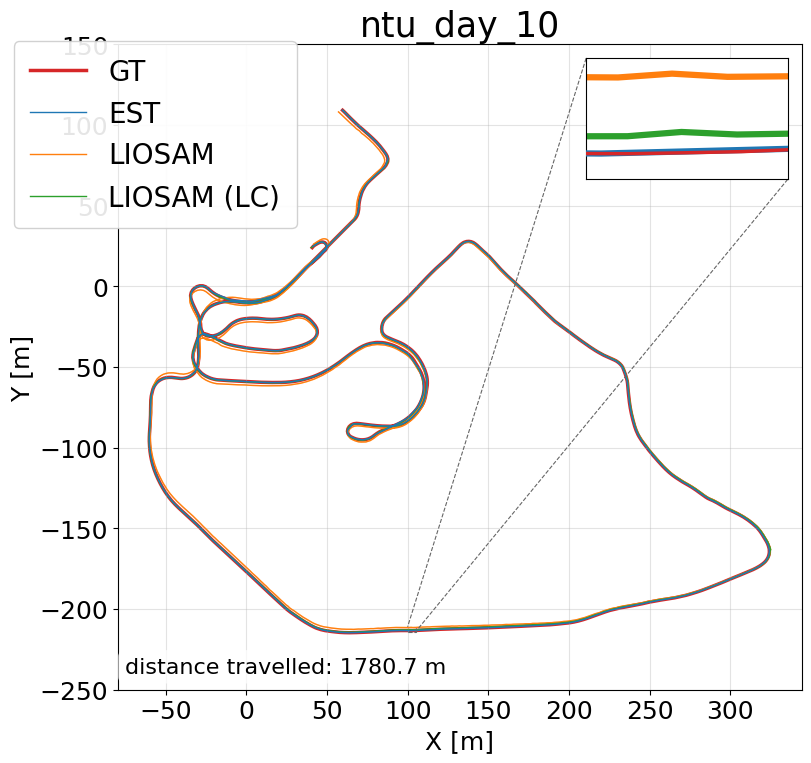

In [143]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# ====== Paths ======
EST_DIR_A = '/home/dat/slict_ws/src/slict/evo/est'        # EST (của bạn) — quat + time
EST_DIR_B = '/home/dat/slict_ws/src/slict/evo/liosam'     # LIOSAM — RPY + time
EST_DIR_C = '/home/dat/slict_ws/src/slict/evo/liosam_lc'  # LIOSAM (LC) — RPY + time
GRT_DIR   = '/home/dat/slict_ws/src/slict/evo/grt'

# ====== Chỉ xử lý 1 (hoặc vài) tập ======
TARGET_SETS = ['ntu_day_10']  # thêm tên khác nếu muốn

# ==== Màu sắc nhất quán ====
COL_EST   = '#1f77b4'  # EST:    xanh dương
COL_LIOS  = '#ff7f0e'  # LIO-SAM: cam
COL_LC    = '#2ca02c'  # LIO-SAM (LC): xanh lá
COL_GT    = '#d62728'  # GT:     đỏ

# ==== NEW: Thiết lập font lớn toàn cục ====
PLT_FONTS = {
    "base": 20,     # cỡ chữ mặc định
    "title": 25,    # tiêu đề figure/axes
    "label": 18,    # nhãn trục
    "tick": 18,     # số trên trục
    "legend": 20,   # chú giải
}
plt.rcParams.update({
    "font.size": PLT_FONTS["base"],
    "axes.titlesize": PLT_FONTS["title"],
    "axes.labelsize": PLT_FONTS["label"],
    "xtick.labelsize": PLT_FONTS["tick"],
    "ytick.labelsize": PLT_FONTS["tick"],
    "legend.fontsize": PLT_FONTS["legend"],
    "figure.titlesize": PLT_FONTS["title"],
})

def euler_rpy_to_quat_wxyz(roll, pitch, yaw, assume_deg_if_large=True):
    """Convert RPY -> quaternion (w,x,y,z). Input mặc định rad; nếu trị số lớn coi là độ."""
    r = np.asarray(roll, dtype=float)
    p = np.asarray(pitch, dtype=float)
    y = np.asarray(yaw, dtype=float)

    if assume_deg_if_large:
        max_abs = np.nanmax(np.abs([np.nanmax(r), np.nanmax(p), np.nanmax(y)]))
        if max_abs > 6.4:  # ~> 2π
            d2r = np.pi / 180.0
            r, p, y = r * d2r, p * d2r, y * d2r

    cr, sr = np.cos(r * 0.5), np.sin(r * 0.5)
    cp, sp = np.cos(p * 0.5), np.sin(p * 0.5)
    cy, sy = np.cos(y * 0.5), np.sin(y * 0.5)

    # yaw(Z)-pitch(Y)-roll(X) order (ZYX)
    qw = cr * cp * cy + sr * sp * sy
    qx = sr * cp * cy - cr * sp * sy
    qy = cr * sp * cy + sr * cp * sy
    qz = cr * cp * sy - sr * sp * cy
    return np.column_stack([qw, qx, qy, qz])


# ---------- Loaders ----------
def load_estimate_est(est_path):
    """EST (của bạn): PCD/TXT bỏ 11 dòng header.
    Cột: x y z intensity timestamp qx qy qz qw"""
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    timestamps = data[:, 4]
    positions = data[:, 0:3]
    quats_wxyz = data[:, [8, 5, 6, 7]]  # reorder: qw qx qy qz
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


def load_estimate_liosam_like(est_path):
    """Cho LIOSAM/LIOSAM_LC: PCD/TXT bỏ 11 dòng header.
    Cột: x y z intensity roll pitch yaw time"""
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    positions = data[:, 0:3]
    roll, pitch, yaw = data[:, 4], data[:, 5], data[:, 6]
    timestamps = data[:, 7]
    quats_wxyz = euler_rpy_to_quat_wxyz(roll, pitch, yaw)
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


def load_groundtruth(grt_path):
    """GT CSV (bỏ 1 dòng header):
    [id, t, x, y, z, qx, qy, qz, qw] -> reorder [w,x,y,z]"""
    data = np.loadtxt(grt_path, delimiter=',', skiprows=1)
    timestamps = data[:, 1]
    positions = data[:, [2, 3, 4]]
    quats_wxyz = data[:, [8, 5, 6, 7]]
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


# ---------- Sync & align ----------
def associate_and_align(traj_est, traj_gtr, max_diff=0.5):
    """Đồng bộ theo thời gian & align est vào khung GT.
    Trả về: (est_aligned, gtr_synced)"""
    est_sync, gtr_sync = sync.associate_trajectories(traj_est, traj_gtr, max_diff=max_diff)
    est_sync.align(gtr_sync)  # in-place
    return est_sync, gtr_sync


# ---------- Legend helper ----------
def place_legend_left(ax, dx_cm=3.0, **kw):
    """
    Đặt legend ở *ngoài* mép trái của axes, lùi dx_cm so với mép trái trục.
    Dùng toạ độ theo figure để không bị ảnh hưởng bởi tight/constrained layout.
    """
    fig = ax.figure
    fig.canvas.draw()  # cập nhật layout trước khi đọc vị trí

    ax_pos = ax.get_position(fig)        # BBox axes trong toạ độ figure [0..1]
    fig_w_in = fig.get_size_inches()[0]  # chiều rộng figure (inch)

    dx_in = dx_cm / 2.54                 # cm -> inch
    dx_fig = dx_in / fig_w_in            # inch -> tỉ lệ figure

    x_anchor = ax_pos.x0 - dx_fig        # dịch sang trái ngoài axes
    y_anchor = ax_pos.y1  - 0.07        # giữ "upper" theo trục

    return ax.legend(
        loc='upper left',
        bbox_to_anchor=(x_anchor, y_anchor),
        bbox_transform=fig.transFigure,
        **kw
    )


# ---------- Distance helper (NEW) ----------
def total_distance_m(traj: evotraj.PoseTrajectory3D) -> float:
    """
    Tính tổng quãng đường đã đi (3D) từ chuỗi vị trí của trajectory (m).
    """
    if traj is None or traj.positions_xyz is None or len(traj.positions_xyz) < 2:
        return 0.0
    pos = np.asarray(traj.positions_xyz, dtype=float)
    diffs = np.diff(pos, axis=0)
    seg_len = np.linalg.norm(diffs, axis=1)  # 3D
    return float(np.nansum(seg_len))


# ---------- Plot helpers ----------
def _as_rgba(color, alpha=1.0):
    r, g, b, _ = mcolors.to_rgba(color)
    return (r, g, b, alpha)


def plot_with_glow(ax, x, y, color, label=None,
                   lw_main=2.0, lw_glow=4.5, glow_alpha=0.28, z=3):
    """Vẽ 2 lớp: lớp glow dày (màu mờ) + nét chính (đậm)."""
    ax.plot(x, y, '-', linewidth=lw_glow, color=_as_rgba(color, glow_alpha), zorder=max(0, z-1))
    return ax.plot(x, y, '-', linewidth=lw_main, color=color, label=label, zorder=z)[0]


def _annotate_gt_distance(ax, gtr_sync):
    """Ghi chú quãng đường GT xuống góc trái của axes."""
    dist_m = total_distance_m(gtr_sync)
    text = f"distance travelled: {dist_m:.1f} m"
    ax.text(
        0.01, 0.02, text,
        transform=ax.transAxes,
        ha='left', va='bottom',
        fontsize=16,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.75, edgecolor='none')
    )


def plot_xy_three_estimates_with_zoom(
    estA_aligned, estB_aligned, estC_aligned, gtr_sync, title,
    inset_xlim=(-28, -25), inset_ylim=(-54, -51),
    zoom=25.0, inset_loc='upper right',
    lw_main=1.0, lw_inset=2.5, lw_gt_inset=2.5,
    lw_glow=1.0, glow_alpha=0.28
):
    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

    # --- Plot chính ---
    plot_with_glow(ax,
        gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1],
        color=COL_GT, label='GT', lw_main=lw_gt_inset, lw_glow=lw_glow, glow_alpha=glow_alpha, z=1)
    plot_with_glow(ax,
        estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1],
        color=COL_EST, label='EST', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=3)
    plot_with_glow(ax,
        estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1],
        color=COL_LIOS, label='LIOSAM', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=2)
    plot_with_glow(ax,
        estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1],
        color=COL_LC, label='LIOSAM (LC)', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=2)

    ax.set_aspect('equal')
    ax.set_title(title, fontsize=PLT_FONTS["title"])
    ax.set_xlabel('X [m]', fontsize=PLT_FONTS["label"])
    ax.set_ylabel('Y [m]', fontsize=PLT_FONTS["label"])
    ax.set_ylim(-250, 150)
    ax.grid(True, alpha=0.35)

    # Legend ngoài bên trái
    place_legend_left(ax, dx_cm=3.0, fontsize=PLT_FONTS["legend"], frameon=True)

    # NEW: ghi chú quãng đường GT ở góc trái
    _annotate_gt_distance(ax, gtr_sync)

    # --- Ô zoom ---
    axins = zoomed_inset_axes(ax, zoom=zoom, loc=inset_loc)

    plot_with_glow(axins,
        gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1],
        color=COL_GT, lw_main=lw_gt_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=4)
    plot_with_glow(axins,
        estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1],
        color=COL_EST, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=3)
    plot_with_glow(axins,
        estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1],
        color=COL_LIOS, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=2)
    plot_with_glow(axins,
        estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1],
        color=COL_LC, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=1)

    axins.set_xlim(*inset_xlim); axins.set_ylim(*inset_ylim)
    axins.set_xticks([]); axins.set_yticks([])
    for spine in axins.spines.values(): spine.set_linewidth(0.8)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4", linestyle="--", linewidth=0.8)

    plt.show()


def process_all_sets():
    # Lọc các tập tồn tại ở cả bốn thư mục và thuộc TARGET_SETS
    sets_a = [d for d in os.listdir(EST_DIR_A) if os.path.isdir(os.path.join(EST_DIR_A, d))]
    sets_b = [d for d in os.listdir(EST_DIR_B) if os.path.isdir(os.path.join(EST_DIR_B, d))]
    sets_c = [d for d in os.listdir(EST_DIR_C) if os.path.isdir(os.path.join(EST_DIR_C, d))]
    sets_g = [d for d in os.listdir(GRT_DIR)   if os.path.isdir(os.path.join(GRT_DIR, d))]

    common_sets = [s for s in TARGET_SETS if (s in sets_a and s in sets_b and s in sets_c and s in sets_g)]

    for subset in common_sets:
        estA_files = glob.glob(os.path.join(EST_DIR_A, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_A, subset, '*.txt'))
        estB_files = glob.glob(os.path.join(EST_DIR_B, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_B, subset, '*.txt'))
        estC_files = glob.glob(os.path.join(EST_DIR_C, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_C, subset, '*.txt'))
        grt_files  = glob.glob(os.path.join(GRT_DIR,   subset, '*.csv'))

        if not estA_files or not estB_files or not estC_files or not grt_files:
            print(f"[WARN] Skipping {subset}: missing EST/LIOSAM/LIOSAM_LC/GT file")
            continue

        estA_path = estA_files[0]
        estB_path = estB_files[0]
        estC_path = estC_files[0]
        grt_path  = grt_files[0]

        print(f"Processing set {subset}...")

        traj_estA = load_estimate_est(estA_path)            # EST của bạn (quat + time)
        traj_estB = load_estimate_liosam_like(estB_path)    # LIOSAM (rpy + time)
        traj_estC = load_estimate_liosam_like(estC_path)    # LIOSAM (LC) (rpy + time)
        traj_gtr  = load_groundtruth(grt_path)

        try:
            # Align từng est vào cùng GT để vẽ chung
            estA_aligned, gtr_syncA = associate_and_align(traj_estA, traj_gtr, max_diff=0.5)
            estB_aligned, gtr_syncB = associate_and_align(traj_estB, traj_gtr, max_diff=0.5)
            estC_aligned, gtr_syncC = associate_and_align(traj_estC, traj_gtr, max_diff=0.5)

            # Chọn GT sync dài nhất để vẽ/ghi chú
            gtrs = [gtr_syncA, gtr_syncB, gtr_syncC]
            gtr_sync = max(gtrs, key=lambda g: g.positions_xyz.shape[0])

            title = f"{subset}"
            plot_xy_three_estimates_with_zoom(
                estA_aligned, estB_aligned, estC_aligned, gtr_sync, title,
                inset_xlim=(100, 105), inset_ylim=(-214, -211),
                zoom=25.0, lw_main=1.0, lw_inset=4.5, lw_gt_inset=2.5
            )

        except Exception as e:
            print(f"[ERROR] {subset}: {e}")
            # fallback: vẽ raw nếu align lỗi
            try:
                fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
                plot_with_glow(ax, traj_estA.positions_xyz[:,0], traj_estA.positions_xyz[:,1], COL_EST,  label='EST (raw)',        lw_main=1.8)
                plot_with_glow(ax, traj_estB.positions_xyz[:,0], traj_estB.positions_xyz[:,1], COL_LIOS, label='LIOSAM (raw)',     lw_main=1.8)
                plot_with_glow(ax, traj_estC.positions_xyz[:,0], traj_estC.positions_xyz[:,1], COL_LC,   label='LIOSAM (LC) (raw)',lw_main=1.8)
                ax.set_aspect('equal')
                ax.set_title(f"{subset} — (raw, align failed)", fontsize=PLT_FONTS["title"])
                ax.set_xlabel('X [m]', fontsize=PLT_FONTS["label"]); ax.set_ylabel('Y [m]', fontsize=PLT_FONTS["label"])
                ax.grid(True, alpha=0.35)

                # Legend ngoài trái cho fallback
                place_legend_left(ax, dx_cm=3.0, fontsize=PLT_FONTS["legend"], frameon=True)

                # NEW: vẫn ghi chú quãng đường GT (dùng traj_gtr trực tiếp)
                _annotate_gt_distance(ax, traj_gtr)

                plt.show()
            except Exception as e2:
                print(f"[WARN] Plot raw failed for {subset}: {e2}")


if __name__ == '__main__':
    process_all_sets()


Processing set ntu_night_04...


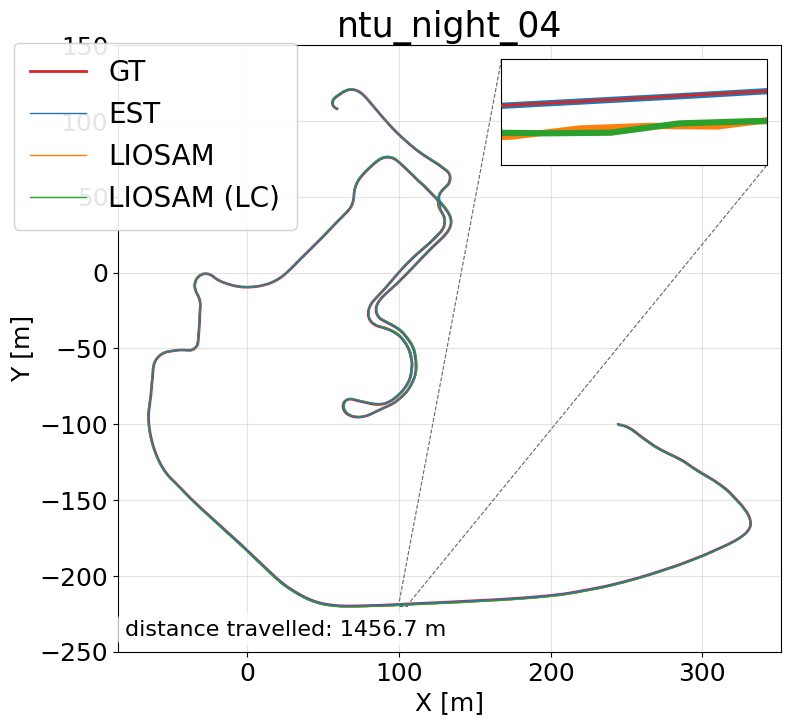

In [144]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# ====== Paths ======
EST_DIR_A = '/home/dat/slict_ws/src/slict/evo/est'        # EST (của bạn) — quat + time
EST_DIR_B = '/home/dat/slict_ws/src/slict/evo/liosam'     # LIOSAM — RPY + time
EST_DIR_C = '/home/dat/slict_ws/src/slict/evo/liosam_lc'  # LIOSAM (LC) — RPY + time
GRT_DIR   = '/home/dat/slict_ws/src/slict/evo/grt'

# ====== Chỉ xử lý 1 (hoặc vài) tập ======
TARGET_SETS = ['ntu_night_04']  # thêm tên khác nếu muốn

# ==== Màu sắc nhất quán ====
COL_EST   = '#1f77b4'  # EST:    xanh dương
COL_LIOS  = '#ff7f0e'  # LIO-SAM: cam
COL_LC    = '#2ca02c'  # LIO-SAM (LC): xanh lá
COL_GT    = '#d62728'  # GT:     đỏ

# ==== Thiết lập font lớn toàn cục ====
PLT_FONTS = {
    "base": 20,     # cỡ chữ mặc định
    "title": 25,    # tiêu đề figure/axes
    "label": 18,    # nhãn trục
    "tick": 18,     # số trên trục
    "legend": 20,   # chú giải
}
plt.rcParams.update({
    "font.size": PLT_FONTS["base"],
    "axes.titlesize": PLT_FONTS["title"],
    "axes.labelsize": PLT_FONTS["label"],
    "xtick.labelsize": PLT_FONTS["tick"],
    "ytick.labelsize": PLT_FONTS["tick"],
    "legend.fontsize": PLT_FONTS["legend"],
    "figure.titlesize": PLT_FONTS["title"],
})

def euler_rpy_to_quat_wxyz(roll, pitch, yaw, assume_deg_if_large=True):
    """Convert RPY -> quaternion (w,x,y,z). Input mặc định rad; nếu trị số lớn coi là độ."""
    r = np.asarray(roll, dtype=float)
    p = np.asarray(pitch, dtype=float)
    y = np.asarray(yaw, dtype=float)

    if assume_deg_if_large:
        max_abs = np.nanmax(np.abs([np.nanmax(r), np.nanmax(p), np.nanmax(y)]))
        if max_abs > 6.4:  # ~> 2π
            d2r = np.pi / 180.0
            r, p, y = r * d2r, p * d2r, y * d2r

    cr, sr = np.cos(r * 0.5), np.sin(r * 0.5)
    cp, sp = np.cos(p * 0.5), np.sin(p * 0.5)
    cy, sy = np.cos(y * 0.5), np.sin(y * 0.5)

    # yaw(Z)-pitch(Y)-roll(X) order (ZYX)
    qw = cr * cp * cy + sr * sp * sy
    qx = sr * cp * cy - cr * sp * sy
    qy = cr * sp * cy + sr * cp * sy
    qz = cr * cp * sy - sr * sp * cy
    return np.column_stack([qw, qx, qy, qz])


# ---------- Loaders ----------
def load_estimate_est(est_path):
    """EST (của bạn): PCD/TXT bỏ 11 dòng header.
    Cột: x y z intensity timestamp qx qy qz qw"""
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    timestamps = data[:, 4]
    positions = data[:, 0:3]
    quats_wxyz = data[:, [8, 5, 6, 7]]  # reorder: qw qx qy qz
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


def load_estimate_liosam_like(est_path):
    """Cho LIOSAM/LIOSAM_LC: PCD/TXT bỏ 11 dòng header.
    Cột: x y z intensity roll pitch yaw time"""
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    positions = data[:, 0:3]
    roll, pitch, yaw = data[:, 4], data[:, 5], data[:, 6]
    timestamps = data[:, 7]
    quats_wxyz = euler_rpy_to_quat_wxyz(roll, pitch, yaw)
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


def load_groundtruth(grt_path):
    """GT CSV (bỏ 1 dòng header):
    [id, t, x, y, z, qx, qy, qz, qw] -> reorder [w,x,y,z]"""
    data = np.loadtxt(grt_path, delimiter=',', skiprows=1)
    timestamps = data[:, 1]
    positions = data[:, [2, 3, 4]]
    quats_wxyz = data[:, [8, 5, 6, 7]]
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quats_wxyz,
        timestamps=timestamps
    )


# ---------- Sync & align ----------
def associate_and_align(traj_est, traj_gtr, max_diff=0.5):
    """Đồng bộ theo thời gian & align est vào khung GT.
    Trả về: (est_aligned, gtr_synced)"""
    est_sync, gtr_sync = sync.associate_trajectories(traj_est, traj_gtr, max_diff=max_diff)
    est_sync.align(gtr_sync)  # in-place
    return est_sync, gtr_sync


# ---------- Legend helper ----------
def place_legend_left(ax, dx_cm=10.0, **kw):
    """Đặt legend ở ngoài mép trái của trục, lùi dx_cm so với mép trái axes."""
    fig = ax.figure
    fig.canvas.draw()  # cập nhật layout trước khi lấy toạ độ

    ax_pos = ax.get_position(fig)        # BBox axes trong toạ độ figure [0..1]
    fig_w_in = fig.get_size_inches()[0]  # chiều rộng figure (inch)
    dx_in = dx_cm / 2.54                 # cm -> inch
    dx_fig = dx_in / fig_w_in            # inch -> tỉ lệ figure

    x_anchor = ax_pos.x0 - dx_fig        # neo ở trái hơn mép trái axes
    y_anchor = ax_pos.y1 - 0.095          # cùng cao độ 'upper' của axes

    return ax.legend(
        loc='upper left',
        bbox_to_anchor=(x_anchor, y_anchor),
        bbox_transform=fig.transFigure,  # toạ độ theo figure
        **kw
    )


# ---------- Distance helper (NEW) ----------
def total_distance_m(traj: evotraj.PoseTrajectory3D) -> float:
    """
    Tính tổng quãng đường đã đi (3D) từ chuỗi vị trí của trajectory (m).
    Để tính theo mặt phẳng XY, thay dòng 'pos = np.asarray(traj.positions_xyz, ...)'
    bằng: 'pos = np.asarray(traj.positions_xyz[:, :2], dtype=float)'.
    """
    if traj is None or traj.positions_xyz is None or len(traj.positions_xyz) < 2:
        return 0.0
    pos = np.asarray(traj.positions_xyz, dtype=float)  # 3D
    diffs = np.diff(pos, axis=0)
    seg_len = np.linalg.norm(diffs, axis=1)
    return float(np.nansum(seg_len))


def _annotate_gt_distance(ax, gtr_sync):
    """Ghi chú quãng đường GT xuống góc trái của axes."""
    dist_m = total_distance_m(gtr_sync)
    text = f"distance travelled: {dist_m:.1f} m"
    ax.text(
        0.01, 0.02, text,
        transform=ax.transAxes,
        ha='left', va='bottom',
        fontsize=16,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.75, edgecolor='none')
    )


# ---------- Plot helpers ----------
def _as_rgba(color, alpha=1.0):
    r, g, b, _ = mcolors.to_rgba(color)
    return (r, g, b, alpha)


def plot_with_glow(ax, x, y, color, label=None,
                   lw_main=2.0, lw_glow=4.5, glow_alpha=0.28, z=3):
    """Vẽ 2 lớp: glow + nét chính."""
    ax.plot(x, y, '-', linewidth=lw_glow, color=_as_rgba(color, glow_alpha), zorder=max(0, z-1))
    return ax.plot(x, y, '-', linewidth=lw_main, color=color, label=label, zorder=z)[0]


def plot_xy_three_estimates_with_zoom(
    estA_aligned, estB_aligned, estC_aligned, gtr_sync, title,
    inset_xlim=(-28, -25), inset_ylim=(-54, -51),
    zoom=25.0, inset_loc='upper right',
    lw_main=1.0, lw_inset=2.5, lw_gt_inset=2.5,
    lw_glow=1.0, glow_alpha=0.28
):
    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

    # --- Plot chính ---
    plot_with_glow(ax,
        gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1],
        color=COL_GT, label='GT', lw_main=lw_gt_inset, lw_glow=lw_glow, glow_alpha=glow_alpha, z=1)
    plot_with_glow(ax,
        estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1],
        color=COL_EST, label='EST', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=3)
    plot_with_glow(ax,
        estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1],
        color=COL_LIOS, label='LIOSAM', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=2)
    plot_with_glow(ax,
        estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1],
        color=COL_LC, label='LIOSAM (LC)', lw_main=lw_main, lw_glow=lw_glow, glow_alpha=glow_alpha, z=2)

    ax.set_aspect('equal')
    ax.set_title(title, fontsize=PLT_FONTS["title"])
    ax.set_xlabel('X [m]', fontsize=PLT_FONTS["label"])
    ax.set_ylabel('Y [m]', fontsize=PLT_FONTS["label"])
    ax.set_ylim(-250,150)
    ax.grid(True, alpha=0.35)

    # Legend ngoài bên trái
    place_legend_left(ax, dx_cm=3.0, fontsize=PLT_FONTS["legend"], frameon=True)

    # NEW: chú thích quãng đường GT (góc trái dưới)
    _annotate_gt_distance(ax, gtr_sync)

    # --- Ô zoom ---
    axins = zoomed_inset_axes(ax, zoom=zoom, loc=inset_loc)

    plot_with_glow(axins,
        gtr_sync.positions_xyz[:, 0], gtr_sync.positions_xyz[:, 1],
        color=COL_GT, lw_main=lw_gt_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=3)
    plot_with_glow(axins,
        estA_aligned.positions_xyz[:, 0], estA_aligned.positions_xyz[:, 1],
        color=COL_EST, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=1)
    plot_with_glow(axins,
        estB_aligned.positions_xyz[:, 0], estB_aligned.positions_xyz[:, 1],
        color=COL_LIOS, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=2)
    plot_with_glow(axins,
        estC_aligned.positions_xyz[:, 0], estC_aligned.positions_xyz[:, 1],
        color=COL_LC, lw_main=lw_inset, lw_glow=lw_glow*0.75, glow_alpha=glow_alpha, z=2)

    axins.set_xlim(*inset_xlim); axins.set_ylim(*inset_ylim)
    axins.set_xticks([]); axins.set_yticks([])
    for spine in axins.spines.values(): spine.set_linewidth(0.8)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4", linestyle="--", linewidth=0.8)

    plt.show()


def process_all_sets():
    # Lọc các tập tồn tại ở cả bốn thư mục và thuộc TARGET_SETS
    sets_a = [d for d in os.listdir(EST_DIR_A) if os.path.isdir(os.path.join(EST_DIR_A, d))]
    sets_b = [d for d in os.listdir(EST_DIR_B) if os.path.isdir(os.path.join(EST_DIR_B, d))]
    sets_c = [d for d in os.listdir(EST_DIR_C) if os.path.isdir(os.path.join(EST_DIR_C, d))]
    sets_g = [d for d in os.listdir(GRT_DIR)   if os.path.isdir(os.path.join(GRT_DIR, d))]

    common_sets = [s for s in TARGET_SETS if (s in sets_a and s in sets_b and s in sets_c and s in sets_g)]

    for subset in common_sets:
        estA_files = glob.glob(os.path.join(EST_DIR_A, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_A, subset, '*.txt'))
        estB_files = glob.glob(os.path.join(EST_DIR_B, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_B, subset, '*.txt'))
        estC_files = glob.glob(os.path.join(EST_DIR_C, subset, '*.pcd')) or \
                     glob.glob(os.path.join(EST_DIR_C, subset, '*.txt'))
        grt_files  = glob.glob(os.path.join(GRT_DIR,   subset, '*.csv'))

        if not estA_files or not estB_files or not estC_files or not grt_files:
            print(f"[WARN] Skipping {subset}: missing EST/LIOSAM/LIOSAM_LC/GT file")
            continue

        estA_path = estA_files[0]
        estB_path = estB_files[0]
        estC_path = estC_files[0]
        grt_path  = grt_files[0]

        print(f"Processing set {subset}...")

        traj_estA = load_estimate_est(estA_path)            # EST của bạn (quat + time)
        traj_estB = load_estimate_liosam_like(estB_path)    # LIOSAM (rpy + time)
        traj_estC = load_estimate_liosam_like(estC_path)    # LIOSAM (LC) (rpy + time)
        traj_gtr  = load_groundtruth(grt_path)

        try:
            # Align từng est vào cùng GT để vẽ chung
            estA_aligned, gtr_syncA = associate_and_align(traj_estA, traj_gtr, max_diff=0.5)
            estB_aligned, gtr_syncB = associate_and_align(traj_estB, traj_gtr, max_diff=0.5)
            estC_aligned, gtr_syncC = associate_and_align(traj_estC, traj_gtr, max_diff=0.5)

            # Chọn GT sync dài nhất để vẽ/ghi chú
            gtrs = [gtr_syncA, gtr_syncB, gtr_syncC]
            gtr_sync = max(gtrs, key=lambda g: g.positions_xyz.shape[0])

            title = f"{subset}"
            plot_xy_three_estimates_with_zoom(
                estA_aligned, estB_aligned, estC_aligned, gtr_sync, title,
                inset_xlim=(100, 105), inset_ylim=(-220, -218),
                zoom=35.0, lw_main=1.0, lw_inset=4.5, lw_gt_inset=2.0
            )

        except Exception as e:
            print(f"[ERROR] {subset}: {e}")
            # fallback: vẽ raw nếu align lỗi
            try:
                fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
                plot_with_glow(ax, traj_estA.positions_xyz[:,0], traj_estA.positions_xyz[:,1], COL_EST,  label='EST (raw)',        lw_main=1.8)
                plot_with_glow(ax, traj_estB.positions_xyz[:,0], traj_estB.positions_xyz[:,1], COL_LIOS, label='LIOSAM (raw)',     lw_main=1.8)
                plot_with_glow(ax, traj_estC.positions_xyz[:,0], traj_estC.positions_xyz[:,1], COL_LC,   label='LIOSAM (LC) (raw)',lw_main=1.8)
                ax.set_aspect('equal')
                ax.set_title(f"{subset} — (raw, align failed)", fontsize=PLT_FONTS["title"])
                ax.set_xlabel('X [m]', fontsize=PLT_FONTS["label"]); ax.set_ylabel('Y [m]', fontsize=PLT_FONTS["label"])
                ax.grid(True, alpha=0.35)

                # Legend ngoài trái cho fallback
                place_legend_left(ax, dx_cm=10.0, fontsize=PLT_FONTS["legend"], frameon=True)

                # NEW: vẫn ghi chú quãng đường GT (dùng traj_gtr trực tiếp)
                _annotate_gt_distance(ax, traj_gtr)

                plt.show()
            except Exception as e2:
                print(f"[WARN] Plot raw failed for {subset}: {e2}")


if __name__ == '__main__':
    process_all_sets()
